In [ ]:
# Bag of Words Sentiment Analyse von McDonalds Reviews und IMBD Daten

## Zielsetzung 
In diesem Notebook teilen wir die Testdaten in positven und Negative Reviews auf. Dadurch haben wir nur zwei Labels. Als common sense Baseline dient dementsprechend 50% accuracy.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers


2023-06-27 15:27:39.665418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Datenvorbereitung inkl. Behandlung bekannter Probleme

### Laden der Daten

In [ ]:
%pip install kaggle

In [ ]:
!kaggle datasets download -d nelgiriyewithana/mcdonalds-store-reviews
!unzip mcdonalds-store-reviews.zip

In [2]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip

 97%|████████████████████████████████████▉ | 25.0M/25.7M [00:13<00:00, 5.82MB/s]
100%|██████████████████████████████████████| 25.7M/25.7M [00:13<00:00, 2.05MB/s]
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [57]:
df_mc = pd.read_csv('McDonald_s_Reviews.csv', encoding="latin-1")
df_imdb = pd.read_csv('IMDB Dataset.csv')


### Löschen der 3 Sterne Bewertungen beim McDonalds Dataset

In [58]:
df_mc = df_mc[df_mc['rating'] != '3 stars']


In [59]:
print(df_mc.columns)
print(df_imdb.columns)

Index(['reviewer_id', 'store_name', 'category', 'store_address', 'latitude ',
       'longitude', 'rating_count', 'review_time', 'review', 'rating'],
      dtype='object')
Index(['review', 'sentiment'], dtype='object')


### Konvertierung der train data zu numpy arrays

In [60]:
data_mc = df_mc['review'].to_numpy()
data_imdb = df_imdb['review'].to_numpy()


### Konvertierung der Datasets von string labels zu Nummern

In [61]:
rating_mapping_imdb = {
    'positive': 1,
    'negative': 0,
}

label_imdb = df_imdb['sentiment'].map(rating_mapping_imdb).to_numpy()


In [62]:
rating_mapping_mc = {
    '1 star': 0,
    '2 stars': 0,
    '4 stars': 1,
    '5 stars': 1
}

labal_mc = df_mc['rating'].map(rating_mapping_mc).to_numpy()

### Daten zusammenführen

In [63]:
data = np.append(data_imdb, data_mc)
label = np.append(label_imdb,labal_mc)
print(data.shape)
print(label.shape)

(78578,)
(78578,)


### Aufteilung in Trainings, Validierungs und Testdaten

In [64]:
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=42)

print(train_data.shape)
print(test_data.shape)
print(train_label)
print(test_label.shape)

(62862,)
(15716,)
[0 1 1 ... 1 1 1]
(15716,)


### Text zu Dictonary Repräsentationen umbauen
Erklärung Menge an Tokens
Erklärung ngrams 
Erklärung multi_hot und warum

In [65]:
text_vectorization = TextVectorization(
 max_tokens=30000,
ngrams=3,
 output_mode="multi_hot",
)

In [66]:
text_vectorization.adapt(train_data) 
text_vectorization.adapt(test_data) 

multi_hot_train_data = text_vectorization(train_data)
multi_hot_test_data = text_vectorization(test_data)

## Erstellung eines entsprechenden künstlichen neuronalen Models sowie geeigente Benchmarks

In [72]:
def get_model(max_tokens=30000, hidden_dim=64):
 inputs = keras.Input(shape=(max_tokens,))
 x = layers.Dense(hidden_dim, activation="relu")(inputs)
 x = layers.Dense(32, activation="relu")(x)
 x = layers.Dropout(0.5)(x)
 x = layers.Dense(16, activation="relu")(x)
 outputs = layers.Dense(1, activation="sigmoid")(x)
 model = keras.Model(inputs, outputs)
 model.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"], 
 )
 return model

model = get_model()
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30000)]           0         
                                                                 
 dense_10 (Dense)            (None, 64)                1920064   
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,922,689
Trainable params: 1,922,689
Non-tra

In [73]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",  # Metric to monitor
        patience=3,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,  # Restore the weights of the best epoch
    )
]
history = model.fit(multi_hot_train_data,train_label,
validation_split=0.4,
 epochs=10, 
 callbacks= callbacks
 )

Epoch 1/10


1179/1179 [==============================] - 27s 22ms/step - loss: 0.3356 - accuracy: 0.8707 - val_loss: 0.2606 - val_accuracy: 0.8989
Epoch 2/10
1179/1179 [==============================] - 25s 21ms/step - loss: 0.1897 - accuracy: 0.9337 - val_loss: 0.2842 - val_accuracy: 0.8959
Epoch 3/10
1179/1179 [==============================] - 26s 22ms/step - loss: 0.1360 - accuracy: 0.9545 - val_loss: 0.3753 - val_accuracy: 0.8986
Epoch 4/10
1179/1179 [==============================] - 27s 23ms/step - loss: 0.0968 - accuracy: 0.9699 - val_loss: 0.5723 - val_accuracy: 0.8989


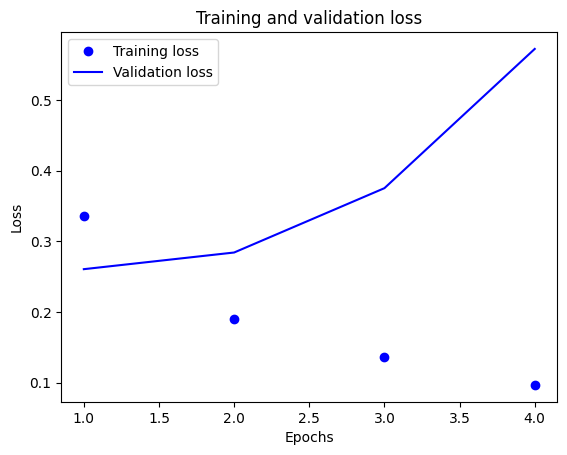

In [74]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [75]:
model.evaluate(multi_hot_test_data, test_label)

492/492 [==============================] - 2s 4ms/step - loss: 0.2444 - accuracy: 0.9051


[0.24439136683940887, 0.9050648808479309]